In [1]:
import torch.nn as nn 
#create a network class to reuse
class Net( nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9,10)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

    def forward(self,x):
        x=nn.functional.relu(self.fc1(x))
        x=nn.functional.relu(self.fc2(x))
        x=nn.functional.relu(self.fc3(x))
        return x
    
net = Net()


In [2]:
from torch.utils.data import Dataset
import pandas as pd
class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy()
        
    # Implement __len__ to return the number of data samples
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx,-1]
        return features, label
    

dataset = WaterDataset('./data.csv')

In [3]:
from torch.utils.data import DataLoader
# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(features, labels)

tensor([[1, 1],
        [1, 1]]) tensor([1, 1])


In [4]:
import torch.optim as optim
optimizer = optim.Adagrad(net.parameters(),lr=0.01)# it addapts the lr
# but it may decrease the lr too fast 
optimizer2 = optim.RMSprop(net.parameters(),lr=0.01)# updates the lr based on the previous gradient
optimizer3 = optim.Adam(net.parameters(),lr=0.01) # RMSprop + gradient momentum

- vanishing gradients : when gradeints get really small and prevent model from training
- exploding gradients : when gradients gets bigger so training diverges

a way to deal with this is initialize the weights in a way that:
- variance of layer inputs = var outputs
- variance of gradients the same before and after a layer 

In [5]:
import torch.nn as nn 
import torch.nn.init as init
#create a network class to reuse
class Net( nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9,10)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight,
                            nonlinearity="sigmoid"
                            )

    def forward(self,x):
        x=nn.functional.relu(self.fc1(x))
        x=nn.functional.relu(self.fc2(x))
        x=nn.functional.sigmoid(self.fc3(x))
        # nn.functional.elu helps againts dying neurons
        return x
    
net = Net() 


batch normalisation : normalizing the output of an activation layer with mean and std of a batch

In [6]:
class Net( nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9,10)
        self.bn1 = nn.BatchNorm1d(10)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight,
                            nonlinearity="sigmoid"
                            )
        def forward(self,x):
            x = self.fc1(x)
            x=nn.functional.bn1(x)
            x=nn.functional.relu(x)
            # ...
            return x
        

# Images

In [7]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
train_trainsforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])
dataset_train = ImageFolder(
    "./clouds/clouds/clouds_train",
    transform=train_trainsforms
)

In [8]:
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,batch_size=1
)

image,label =next(iter(dataloader_train))
print(image.shape)

torch.Size([1, 3, 128, 128])


1 for batch size 

3 for the colors 

128 ,128 for height and weight


In [9]:
# to print it 
image=image.squeeze().permute(1,2,0)
print(image.shape)

torch.Size([128, 128, 3])


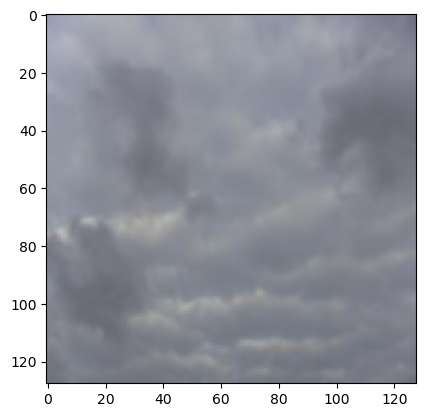

In [10]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.show()

In [13]:
print(label)

tensor([6])


in data augmentation we apply random tranformation to the images to get more data like rotation fliping ..

makes the model more robust to changes and variations 

In [14]:
train_trainsforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
        transforms.ToTensor(),
    transforms.Resize((128,128))
])
